# **Problème du secrétaire**
#### ***Séminaire de Modélisation Statistique - 2A ENSAE***

## 1. Cadre du problème

Dans le cadre du Séminaire de Modélisation Statistique, nous avons assisté à **une intervention de Vianney Perchet (CREST, Criteo) sur les algorithmes de matching**. Nous avons souhaité travailler sur **le problème du secrétaire** aussi appelé la « règle des 37 % » qui nous avait été présenté en interlude.

Le problème du secrétaire est le suivant : étant donné n nombres qui arrivent les uns après les autres et dans un ordre aléatoire, quelle est **la stratégie qui maximise la probabilité de sélectionner le plus élevé** ? Ce problème tient au fait que la décision d’accepter ou non un nombre doit être faite immédiatement et de manière irrévocable, sans connaître les nombres qui arrivent par la suite.

Une **stratégie naïve** serait de sélectionner le premier nombre : la probabilité que ça soit le plus élevé est de 1/n ! Cependant, **on peut maximiser cette probabilité** jusqu’à **la constante 1/e, au moins** : il s’agit alors d’observer un échantillon composé des n/e premiers nombres (soit 37 % des nombres) puis de sélectionner ensuite le premier nombre supérieur au maximum de l’échantillon. Avec cette stratégie, si le maximum est dans l’échantillon, alors on sélectionne le dernier nombre et on a perdu. En revanche, si le maximum n’est pas dans l’échantillon mais que le deuxième plus grand y est, alors on a gagné.

Nous souhaitons **introduire des contraintes à ce problème** afin de **redéfinir la stratégie optimale qui permet de maximiser la probabilité de sélectionner le meilleur candidat**. En effet, un cas d’usage du problème du secrétaire est **le recrutement** : les candidats peuvent être représentés par des nombres qui reflètent un niveau de compétence, par exemple. Or, dans la réalité, les entreprises composent aussi avec **des contraintes de diversité ou budgétaires**. De fait, il y a un **coût d’opportunité** à ne pas avoir de diversité (l’entreprise perd en créativité, la marque employeur est affectée, etc.) ou à recruter un candidat avec des prétentions salariales trop fortes (inégalités salariales dans l’entreprise, moins de capacité de recrutement pour les prochains besoins).

## 2. Etat de l'art

### 2.1. Démonstration du problème du secrétaire

*L'objectif de cette section est de montrer empiriquement la règle des 37 %. Pour la démonstration mathématique, nous vous invitons à vous référer à l'article suivant : "La loi du 1/e" (Carine Bartholmé, 2011)*

Lien de l'article : https://bssm.ulb.ac.be/data/books/Bssm-2011-Carine-Bartholme.pdf

In [4]:
import numpy as np

def generate_candidates(n):
    candidates = np.arange(1, n + 1)
    np.random.shuffle(candidates)
    return list(candidates)

Pour nos n candidats, **on rejette les int(round(n/np.e)) premiers** : ils constituent **un échantillon**. On retient le premier candidat avec un meilleur niveau que le meilleur de notre échantillon (d'où l'index 0 dans chosen_candidate = better_candidates[0]). S'il n'y en a pas (parce que le meilleur candidat est dans notre échantillon), alors on retient le dernier candidat.

In [147]:
def choose_candidate(candidates: list, prop = 1 / np.e):
    sample_size = int(round(len(candidates) * prop)) 
    sample = candidates[:sample_size]
    best_from_sample = np.min(candidates[:sample_size])
    other_candidates = candidates[sample_size:]
    better_candidates = [candidate for candidate in other_candidates if candidate < best_from_sample]
    if len(better_candidates) > 0:
        chosen_candidate = better_candidates[0]
    else:
        chosen_candidate = other_candidates[-1]
    return chosen_candidate

On réalise 100 000 simulations pour 100 candidats et on trace les courbes de fréquence avec Matplotlib.
On constate que cette stratégie permet de sélectionner fréquemment le meilleur candidat : environ 37 000 fois sur 100 000 (soit **37 % du temps**).

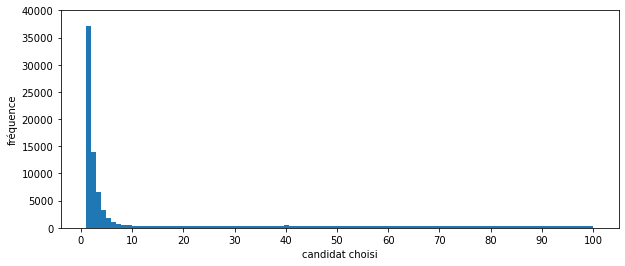

"\nplt.figure(figsize = (10, 6))\nplt.plot(np.cumsum(np.histogram(sim, bins = 100)[0]) / 100000)\nplt.ylim(0,1)\nplt.xlim(0, 100)\nplt.yticks(np.arange(0, 1.1, 0.1))\nplt.xticks(np.arange(0, 101, 10))\nplt.xlabel('candidat choisi')\nplt.ylabel('fréquence cumulée')\nplt.show()\n"

In [151]:
import matplotlib.pyplot as plt 

sim = np.array([choose_candidate(generate_candidates(n = 100)) for i in range(100000)])
plt.figure(figsize = (10, 4))
plt.hist(sim, bins = 100)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 40000)
plt.xlabel('candidat choisi')
plt.ylabel('fréquence')
plt.show()

# graphe pour obtenir la fréquence cumulée du choix du meilleur candidat
"""
plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(np.histogram(sim, bins = 100)[0]) / 100000)
plt.ylim(0,1)
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 101, 10))
plt.xlabel('candidat choisi')
plt.ylabel('fréquence cumulée')
plt.show()
"""

On cherche à déterminer empiriquement la proportion optimale de candidat à intégrer à l'échantillon. Pour cela, on calcule les fréquences moyennes du choix du meilleur candidat en fonction de la proportion.

processing: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


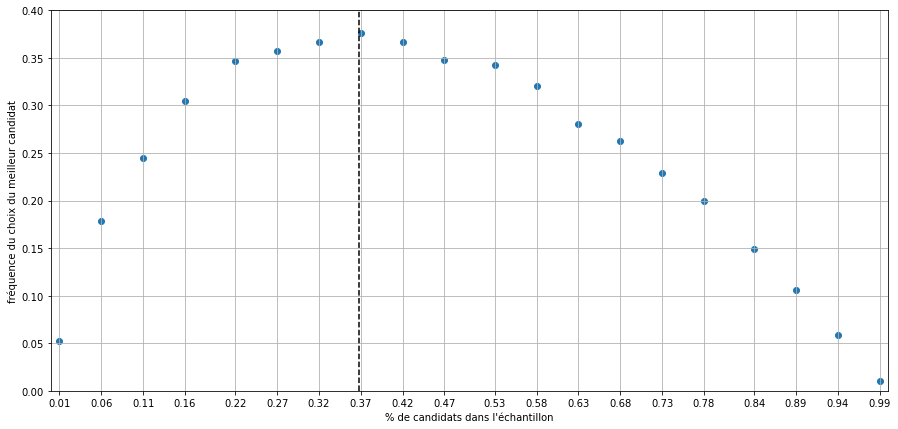

In [152]:
from tqdm import tqdm

props = [np.round(prop, 2) for prop in list(np.linspace(0.01, 0.99, num = 20))]
freq_best_candidate = []
for prop in tqdm(props, "processing"):
    sim = [choose_candidate(generate_candidates(100), prop) for i in range(10000)]
    freq_best_candidate.append(np.histogram(sim, bins = 100)[0][0] / 10000)

plt.figure(figsize=(15, 7))
plt.scatter(props, freq_best_candidate)
plt.xlim(0, 1)
plt.xticks(props)
plt.ylim(0, 0.4)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("fréquence du choix du meilleur candidat")
plt.grid(True)
plt.axvline(1 / np.e, ls = '--', c = 'black')
plt.show()

On constate que c'est bien avec une stratégie où on intègre 37 % des candidats dans l'échantillon (soit 1/e) qu'on maximise la probabilité de tirer le meilleur candidat.

### 2.2. k-Secretary-Problem

*Sélectionner au moins / au plus k candidats -> maximiser une fonction convexe*

## 3. Problème du secrétaire sous contraintes

*Disclaimer : on part du principe que les entreprises discriminent plus les femmes que les hommes, ceci étant le cas dans la plupart des secteurs (mais pas tous)*

**Idées** :

- attention à ne pas avoir le cas où l’entreprise traite **deux problèmes indépendants** (k femmes parmi n recrutements = recrutement des hommes puis des femmes) -> les problèmes "au moins x femmes / y personnes de couleur parmi k recrutements" ou de bonus parité (ou de pénalité) permettent d'avoir une dépendance dans la sélection (si je recrute un homme alors je dois recruter plus de femmes par la suite, ou inversement si je recrute une femme alors je peux recruter plus d'hommes par la suite) ;

- modéliser l'utilité de l'entreprise par une fonction convexe type Cobb Douglas (valorise la diversité) ;

- modéliser la distribution des femmes et des hommes (à intégrer à la stratégie de l'entreprise) ;

## 4. Ressources

- https://medium.com/intriguing-algorithms/thirty-seven-percent-rule-b13c41d83588 : explication du problème du secrétaire
- https://www.imrankhan.dev/pages/Solving%20the%20secretary%20problem%20with%20Python.html : simulation du problème du secrétaire
- https://docs.microsoft.com/fr-fr/archive/msdn-magazine/2016/september/test-run-the-secretary-problem : simulation du problème du secrétaire (en C#)
- https://github.com/RoyZhang7/secretary-problem : simulation problème du secrétaire
- https://github.com/fgreve/at/blob/master/_R/2016-08-03-secretary.Rmd : simulation problème du secrétaire avec R
- https://arxiv.org/pdf/1905.04941.pdf : article intéressant (cardinality constraint)
- https://drops.dagstuhl.de/opus/volltexte/2019/11514/pdf/LIPIcs-ISAAC-2019-18.pdf : k-secretary problem
- https://www.sigecom.org/exchanges/volume_8/2/buchbinder.pdf : one-to-one correspondence between mechanisms for the secretary problem and feasible solutions to the linear program